# Deep Q Network (DQN)

This notebook is to create an agent that works using Deep Q Network (DQN) over the generic Q Learning approach.

<!-- For submission check https://www.kaggle.com/aithammadiabdellatif/lux-submission -->
## Q Learning

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.

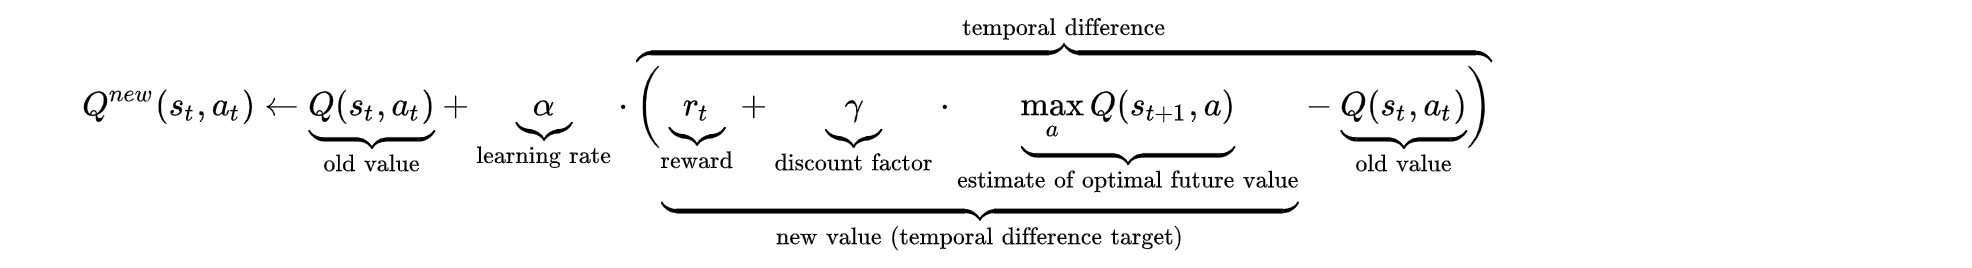

![](https://github.com/aaiit/lux/raw/main/lux.png)

In [ ]:
!pip install -q kaggle-environments -U
!cp -r ../input/lux-ai-2021/* .
!git clone https://github.com/aaiit/lux-AI.git

In [ ]:
!cp lux-AI/Game/*.py . 
!cp lux-AI/Game/lux/* lux/ 
!cp lux-AI/*.png .

<!-- Steps involved in reinforcement learning using deep Q-learning networks (DQNs):

1. All the past experience is stored by the user in memory
2. The next action is determined by the maximum output of the Q-network
3. The loss function here is mean squared error of the predicted Q-value and the target Q-value – Q*. This is basically a regression problem. However, we do not know the target or actual value here as we are dealing with a reinforcement learning problem. Going back to the Q-value update equation derived fromthe Bellman equation. we have: -->

In [ ]:
from kaggle_environments import make
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.game_objects import Unit
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math, sys
import numpy as np
import random
from IPython.display import clear_output 
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_hub as hub
from collections import deque
import random
import math

# The input of the model 

In [ ]:
def get_inputs(game_state):
    # Teh shape of the map
    w,h = game_state.map.width, game_state.map.height
    # The map of ressources
    M = [ [0  if game_state.map.map[j][i].resource==None else game_state.map.map[j][i].resource.amount for i in range(w)]  for j in range(h)]
    
    M = np.array(M).reshape((h,w,1))
    
    # The map of units features
    U_player = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]    
    units = game_state.player.units
    for i in units:
        U_player[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]
    U_player = np.array(U_player)
    
    U_opponent = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]
    units = game_state.opponent.units
    for i in units:
        U_opponent[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]

    U_opponent = np.array(U_opponent)
    
    # The map of cities featrues
    e = game_state.player.cities
    C_player = [ [[0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C_player[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep]
    C_player = np.array(C_player)

    e = game_state.opponent.cities
    C_opponent = [ [[0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C_opponent[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep]
    C_opponent = np.array(C_opponent)
    
    # stacking all in one array
    E = np.dstack([M,U_opponent,U_player,C_opponent,C_player])
    return E

# Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_hub as hub
from collections import deque
import random
import math
from tensorflow.keras import backend as K

"""
we add two lines:

e= tf.keras.backend.max(y_true,axis = -1)
y_pred*= K.stack([e]*8, axis=-1)
    
to make the positions which doesn't contain neither unit or city by zero in the prediction probabilities, in order to focus only on the main occupied positions.
"""

def custom_mean_squared_error(y_true, y_pred):
    y_units_true = y_true[:,:,:,:6]
    y_cities_true = y_true[:,:,:,6:]

    y_units_pred = y_pred[:,:,:,:6]
    y_cities_pred = y_pred[:,:,:,6:]
    
    
    is_unit = tf.keras.backend.max(y_units_true,axis = -1)
    is_city = tf.keras.backend.max(y_cities_true,axis = -1)
    
    y_units_pred*= K.stack([is_unit]*6, axis=-1)
    y_cities_pred*= K.stack([is_city]*2, axis=-1)
    
    loss1 = K.square(y_units_pred - y_units_true)#/K.sum(is_unit)
    loss2 = K.square(y_cities_pred - y_cities_true)#/K.sum(is_city)
    return K.concatenate([loss1,loss2])

def units_accuracy(y_true, y_pred):
    y_units_true = y_true[:,:,:,:6]
    y_cities_true = y_true[:,:,:,6:]

    y_units_pred = y_pred[:,:,:,:6]
    y_cities_pred = y_pred[:,:,:,6:]
    
    is_unit = tf.keras.backend.max(y_units_true,axis = -1)
    y_units_pred*= K.stack([is_unit]*6, axis=-1)
    return K.cast(K.equal(y_units_true, K.round(y_units_pred)), "float32")/K.sum(is_unit)

def cities_accuracy(y_true, y_pred):
    y_units_true = y_true[:,:,:,:6]
    y_cities_true = y_true[:,:,:,6:]

    y_units_pred = y_pred[:,:,:,:6]
    y_cities_pred = y_pred[:,:,:,6:]
    
    is_city = tf.keras.backend.max(y_cities_true,axis = -1)
    y_cities_pred*= K.stack([is_city]*2, axis=-1)
    
    return K.cast(K.equal(y_cities_true, K.round(y_cities_pred)), "float32")/K.sum(is_city)


def get_model(s):
    inputs = keras.Input(shape=(s,s,17),name = 'The game map')
    f = layers.Flatten()(inputs)   
    h,w= s,s
    f = layers.Dense(w*h,activation = "sigmoid")(f)
    f = layers.Reshape((h,w,-1))(f)
    units = layers.Dense(6,activation = "softmax",name = "Units_actions")(f)
    cities = layers.Dense(2,activation = "sigmoid",name = "Cities_actions")(f)
    output = layers.Concatenate()([units,cities])
    model = keras.Model(inputs = inputs, outputs = output)
    model.compile(optimizer= "adam", loss= custom_mean_squared_error ,metrics = ["accuracy"])
    
    return model


model =get_model(12)
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

The function will take the units of the game stat and predict the options and directions in case of move option gathered in actions list

In [ ]:
def get_prediction_actions(y,player):
    # move
    option = np.argmax(y,axis = 2) 
    # c s n w e build_city & research & buid_worker  
    actions = []
    for i in player.units:
#         print(option.shape,i.pos.y,i.pos.x)
        d = "csnwe#############"[option[i.pos.y,i.pos.x]]
        if option[i.pos.y,i.pos.x]<5:actions.append(i.move(d))
        elif option[i.pos.y,i.pos.x]==5 and i.can_build(game_state.map):actions.append(i.build_city())
    
    city_tiles: List[CityTile] = []
    for city in player.cities.values():
        for city_tile in city.citytiles:
#             city_tiles.append(city_tile)
            if option[city_tile.pos.y,city_tile.pos.x]==6:
                action = city_tile.research()
                actions.append(action)
            if option[city_tile.pos.y,city_tile.pos.x]==7:
                action = city_tile.build_worker()
                actions.append(action)
    return actions,option

# RL agent

In [ ]:
Last_State = {}
learning_rate = 0.01
gamma = 0.95
epsilon = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995
game_state = None
model = None
last_reward = 0
W = 0
def agent(observation, configuration):
    global game_state,epsilon,model,last_reward,W
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
    else:
        game_state._update(observation["updates"])
    

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height

    # Get Prediction of actions
    x = get_inputs(game_state)
    y = model.predict(np.asarray([x]))[0]
    
    if random.random()<epsilon:
        y = np.random.rand(*y.shape)
    print("eps ",epsilon,end= " | ") 
    actions,option = get_prediction_actions(y,player)
    
    print("Reward",observation["reward"])

    
    if observation.player in Last_State:
        _x,_y,_player,_option = Last_State[observation.player]
        state,next_state,reward = _x,x,observation["reward"]
        
        # Reward 
        if reward > last_reward:r=1
        elif reward < last_reward:r = -1
        else:r = 0
        
        # Q-learning update

        for i in _player.units:
            Q1 = _y[i.pos.y,i.pos.x][_option[i.pos.y,i.pos.x]]
            Q2 = y[i.pos.y,i.pos.x][_option[i.pos.y,i.pos.x]]
            v = r + gamma*(Q2 - Q1)
            _y[i.pos.y,i.pos.x][_option[i.pos.y,i.pos.x]] += learning_rate*v

        _y = y + learning_rate*_y
        
        states = [state]
        _y_ = [_y]
        
        model.fit(np.asarray(states),np.asarray(_y_), epochs=1, verbose=1)
        if epsilon > epsilon_final:
            epsilon*= epsilon_decay
    Last_State[observation.player] = [x,y,player,option]
    last_reward = observation["reward"]
    return actions

In [ ]:
episodes = 100

# RL training
sizes = [12,16,24,32]

for size in sizes:
    # Inistialise the model
    model= get_model(size)
    Last_State = {}
    for eps in range(episodes):
        epsilon = 0.2 # Maintaining exploration
        clear_output()
        print("=== Episode {} ===".format(eps))
        env = make("lux_ai_2021", debug=True, configuration={"annotations": True, "width":size, "height":size})
        steps = env.run(["simple_agent", agent])
    # Save the model
    model.save_weights("model_%d.h5"%size)

# Submission

In [ ]:
!rm lux -r
!cp -r ../input/lux-ai-2021/* .

In [ ]:
%%writefile agent.py
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.game_objects import Unit
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math, sys
import numpy as np
import random
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import random
import math

from pathlib import Path
p = Path('/kaggle_simulations/agent/')
if p.exists():
    sys.path.append(str(p))
else:
    p = Path('__file__').resolve().parent


game_state = None

model = None

def get_inputs(game_state):
    # Teh shape of the map
    w,h = game_state.map.width, game_state.map.height
    # The map of ressources
    M = [ [0  if game_state.map.map[j][i].resource==None else game_state.map.map[j][i].resource.amount for i in range(w)]  for j in range(h)]
    
    M = np.array(M).reshape((h,w,1))
    
    # The map of units features
    U_player = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]    
    units = game_state.player.units
    for i in units:
        U_player[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]
    U_player = np.array(U_player)
    
    U_opponent = [ [[0,0,0,0,0] for i in range(w)]  for j in range(h)]
    units = game_state.opponent.units
    for i in units:
        U_opponent[i.pos.y][i.pos.x] = [i.type,i.cooldown,i.cargo.wood,i.cargo.coal,i.cargo.uranium]

    U_opponent = np.array(U_opponent)
    
    # The map of cities featrues
    e = game_state.player.cities
    C_player = [ [[0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C_player[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep]
    C_player = np.array(C_player)

    e = game_state.opponent.cities
    C_opponent = [ [[0,0,0] for i in range(w)]  for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C_opponent[i.pos.y][i.pos.x] = [i.cooldown,e[k].fuel,e[k].light_upkeep]
    C_opponent = np.array(C_opponent)
    
    # stacking all in one array
    E = np.dstack([M,U_opponent,U_player,C_opponent,C_player])
    return E


def get_model(s):
    input_shape = (s,s,17)
    inputs = keras.Input(shape= input_shape,name = 'The game map')
    f = layers.Flatten()(inputs)   
    h,w,_ = get_inputs(game_state).shape
    print(h,w)
#     output = layers.Dense(w*h*8,activation = "sigmoid")(f)
    
    f = layers.Dense(w*h,activation = "sigmoid")(f)
    f = layers.Reshape((h,w,-1))(f)
    units = layers.Dense(6,activation = "softmax",name = "Units_actions")(f)
    
    cities = layers.Dense(2,activation = "sigmoid",name = "Cities_actions")(f)
    
    output = layers.Concatenate()([units,cities])
    model = keras.Model(inputs = inputs, outputs = output)
    return model



def get_prediction_actions(y,player):
    # move
    option = np.argmax(y,axis = 2) 
    # c s n w e build_city & research & buid_worker  
    actions = []
    for i in player.units:
#         print(option.shape,i.pos.y,i.pos.x)
        d = "csnwe#############"[option[i.pos.y,i.pos.x]]
        if option[i.pos.y,i.pos.x]<5:actions.append(i.move(d))
        elif option[i.pos.y,i.pos.x]==5 and i.can_build(game_state.map):actions.append(i.build_city())
    
    for city in player.cities.values():
        for city_tile in city.citytiles:
            if option[city_tile.pos.y,city_tile.pos.x]==6:
                action = city_tile.research()
                actions.append(action)
            if option[city_tile.pos.y,city_tile.pos.x]==7:
                action = city_tile.build_worker()
                actions.append(action)
    return actions,option

def agent(observation, configuration):
    global game_state,epsilon,model
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
        print("Creating model..")
        model =get_model(game_state.map.width)
        print("Load model weight..")
        try:
            model.load_weights( str(p/'model%d.h5'%game_state.map.width),  by_name=True, skip_mismatch=True)
        except Exception as e:
            print('Error in model load')
            print(e)
#         model = tf.keras.models.load_model('model.h5')
        print("Done crating mdoel")
        
        
    else:
        game_state._update(observation["updates"])
    

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height

    # Get Prediction of actions
    x = get_inputs(game_state)
    y = model.predict(np.asarray([x]))[0]
    actions,_ = get_prediction_actions(y,player)
    return actions

In [ ]:
!tar  --exclude="*.png" -czf submission.tar.gz *

In [ ]:
# from kaggle_environments import make
# import json
# # run another match but with our empty agent
# env = make("lux_ai_2021", configuration={"seed": 56221, "loglevel": 2}, debug=False)
# steps = env.run(["./agent.py", "./agent.py"])

In [ ]:
# env.render(mode="ipython", width=600, height=800)